# Predicting the upvote ratio of a joke from its text(2)
We will use this measure as a proxy for how funny a joke is. In this notebook we use LSTM regression model.

[prev: regression using linear regression model](reddit_jokes_upvote_ratio_prediction_linreg.ipynb)  

[next: multi-class classification using logistic regression](reddit_jokes_upvote_ratio_prediction_logreg.ipynb)

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import Counter
from tqdm import tqdm
import nltk

# Ensure nltk's tokenizers are downloaded
nltk.download('punkt')

# Dataset class
class JokesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.float)

class JokesLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, output_dim, dropout_rate=0.5):
        super(JokesLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)  # Apply dropout
        x = self.batch_norm(x)
        x = self.fc(x)
        return x
# Function to evaluate the model
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
    return total_loss / len(loader)

#def main():
    # Load and preprocess data
df = pd.read_csv('./data/reddit_jokes_slim_processed.csv')
texts = df['thread_title'] + ' ' + df['thread_selftext']
targets = df['thread_upvote_ratio']

# Tokenize text
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Build a vocabulary and assign indices to words
word_counts = Counter(word for sentence in tokenized_texts for word in sentence)
vocab = {word: i + 1 for i, (word, _) in enumerate(word_counts.most_common())}
vocab_size = len(vocab) + 1

# Convert text to sequences of indices
max_seq_len = 50
sequences = [[vocab.get(word, 0) for word in sentence] for sentence in tokenized_texts]  # Convert words to indices
padded_sequences = [seq + [0] * (max_seq_len - len(seq)) if len(seq) < max_seq_len else seq[:max_seq_len] for seq in sequences]
X = np.array(padded_sequences, dtype=np.int64)

# Ensure targets are floats and convert to NumPy array
y = np.array(df['thread_upvote_ratio'].values, dtype=np.float32)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Hyperparameters
embed_dim = 100
hidden_dim = 128
num_layers = 1
output_dim = 1
batch_size = 32

# DataLoaders
train_loader = DataLoader(JokesDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(JokesDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(JokesDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Model, loss function, and optimizer
model = JokesLSTM(vocab_size, embed_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-5)

min_val_loss = float('inf')  # Initialize min_val_loss as infinity
early_stop_count = 0
patience = 3  # Number of epochs to wait for improvement before stopping
epochs = 20
# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    val_loss = evaluate_model(model, val_loader, criterion)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    #if val_loss < min_val_loss:
    #    min_val_loss = val_loss
    #    early_stop_count = 0
    #else:
    #    early_stop_count += 1
    #    if early_stop_count >= patience:
    #        print("Early stopping triggered")
    #        break

# Final evaluation on test set
test_loss = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')

# Calculating regression quality metrics
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(targets.tolist())

# Calculate MSE and R-squared
predictions = np.array(predictions)
actuals = np.array(actuals)
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MSE: {mse:.4f}, Test R2: {r2:.4f}')

#if __name__ == '__main__':
#    main()


[nltk_data] Downloading package punkt to /Users/alishahed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/alishahed/.pyenv/versions/3.9.8/envs/ds_ve_39_DS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 1/20: 100%|██████████| 698/698 [00:18<00:00, 37.88it/s]


Epoch 1/20, Training Loss: 0.1358, Validation Loss: 0.0498


Epoch 2/20: 100%|██████████| 698/698 [00:18<00:00, 38.09it/s]


Epoch 2/20, Training Loss: 0.0576, Validation Loss: 0.0494


Epoch 3/20: 100%|██████████| 698/698 [00:17<00:00, 39.11it/s]


Epoch 3/20, Training Loss: 0.0537, Validation Loss: 0.0495


Epoch 4/20: 100%|██████████| 698/698 [00:17<00:00, 39.23it/s]


Epoch 4/20, Training Loss: 0.0527, Validation Loss: 0.0535


Epoch 5/20: 100%|██████████| 698/698 [00:18<00:00, 38.42it/s]


Epoch 5/20, Training Loss: 0.0525, Validation Loss: 0.0493


Epoch 6/20: 100%|██████████| 698/698 [00:17<00:00, 39.36it/s]


Epoch 6/20, Training Loss: 0.0519, Validation Loss: 0.0495


Epoch 7/20: 100%|██████████| 698/698 [00:18<00:00, 38.49it/s]


Epoch 7/20, Training Loss: 0.0517, Validation Loss: 0.0490


Epoch 8/20: 100%|██████████| 698/698 [00:17<00:00, 39.72it/s]


Epoch 8/20, Training Loss: 0.0512, Validation Loss: 0.0497


Epoch 9/20: 100%|██████████| 698/698 [00:17<00:00, 39.97it/s]


Epoch 9/20, Training Loss: 0.0502, Validation Loss: 0.0483


Epoch 10/20: 100%|██████████| 698/698 [00:17<00:00, 39.75it/s]


Epoch 10/20, Training Loss: 0.0482, Validation Loss: 0.0470


Epoch 11/20: 100%|██████████| 698/698 [00:17<00:00, 39.17it/s]


Epoch 11/20, Training Loss: 0.0457, Validation Loss: 0.0482


Epoch 12/20: 100%|██████████| 698/698 [00:17<00:00, 40.75it/s]


Epoch 12/20, Training Loss: 0.0415, Validation Loss: 0.0467


Epoch 13/20: 100%|██████████| 698/698 [00:17<00:00, 39.77it/s]


Epoch 13/20, Training Loss: 0.0374, Validation Loss: 0.0537


Epoch 14/20: 100%|██████████| 698/698 [00:17<00:00, 40.14it/s]


Epoch 14/20, Training Loss: 0.0328, Validation Loss: 0.0524


Epoch 15/20: 100%|██████████| 698/698 [00:17<00:00, 40.36it/s]


Epoch 15/20, Training Loss: 0.0289, Validation Loss: 0.0607


Epoch 16/20: 100%|██████████| 698/698 [00:17<00:00, 40.47it/s]


Epoch 16/20, Training Loss: 0.0254, Validation Loss: 0.0554


Epoch 17/20: 100%|██████████| 698/698 [00:17<00:00, 40.48it/s]


Epoch 17/20, Training Loss: 0.0231, Validation Loss: 0.0650


Epoch 18/20: 100%|██████████| 698/698 [00:17<00:00, 40.39it/s]


Epoch 18/20, Training Loss: 0.0211, Validation Loss: 0.0610


Epoch 19/20: 100%|██████████| 698/698 [00:17<00:00, 40.53it/s]


Epoch 19/20, Training Loss: 0.0192, Validation Loss: 0.0571


Epoch 20/20: 100%|██████████| 698/698 [00:17<00:00, 40.17it/s]


Epoch 20/20, Training Loss: 0.0180, Validation Loss: 0.0586
Test Loss: 0.0603
Test MSE: 0.0603, Test R2: -0.1695


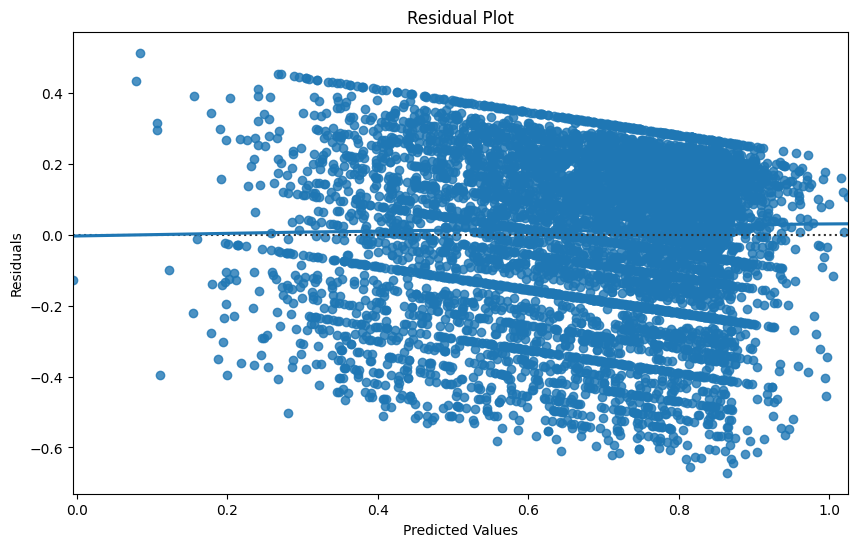

In [12]:
y_pred = predictions
y_test = actuals

plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=actuals, lowess=True)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

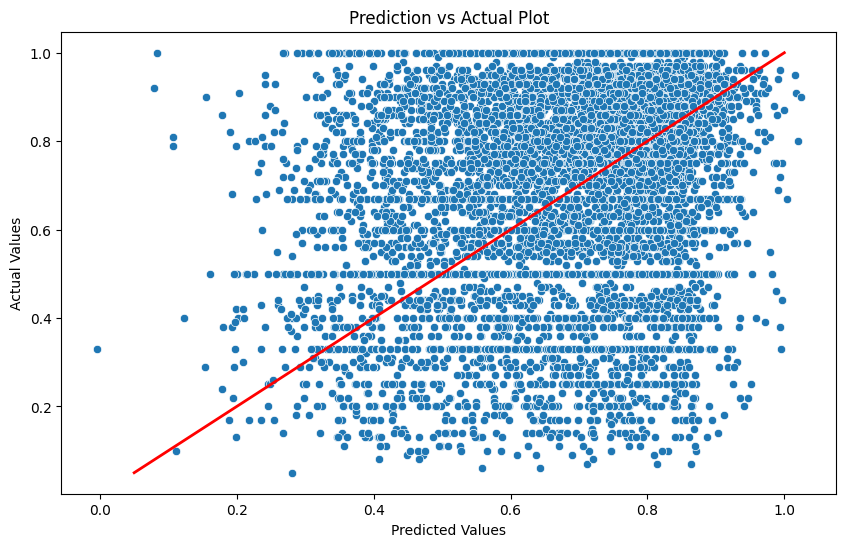

In [13]:
# Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Prediction vs Actual Plot')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Reference line
plt.show()

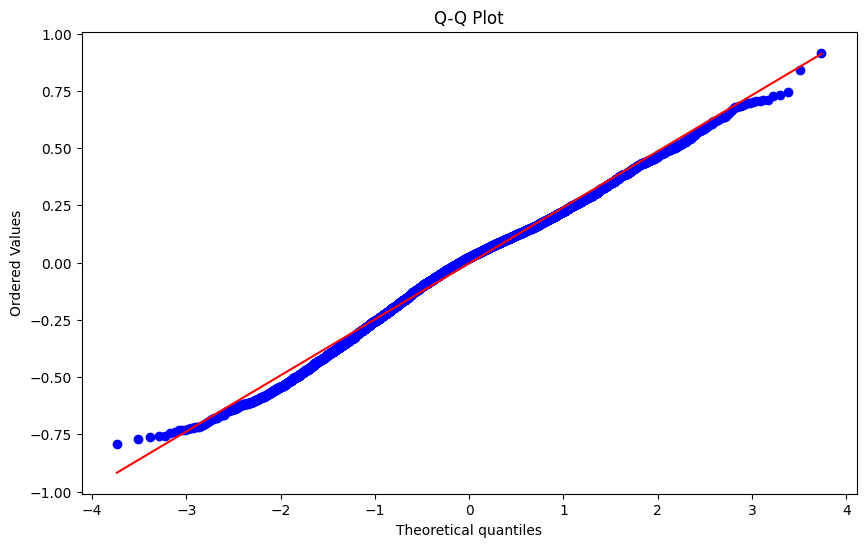

In [14]:
# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(y_test - y_pred, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

After adding multiple methods to prevent the over-fitting,including batch normalization, regularization, and Dropout layer, I still see the over-fitting. Next attempt will be to change the problem statement to multi-class classification and see the performance of the model.